In [22]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.ticker as plticker
import os, time
from skimage import io
from skimage.feature import hog
from sklearn import svm
from sklearn import metrics
import pickle

plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams.update({'font.size': 12})

In [23]:
DIR = 'Individual_Component'

0.100s runtime: Individual_Component\train\train_positive_A\00000000\item_00000000.pnm
HOG descriptor size: (3840,)


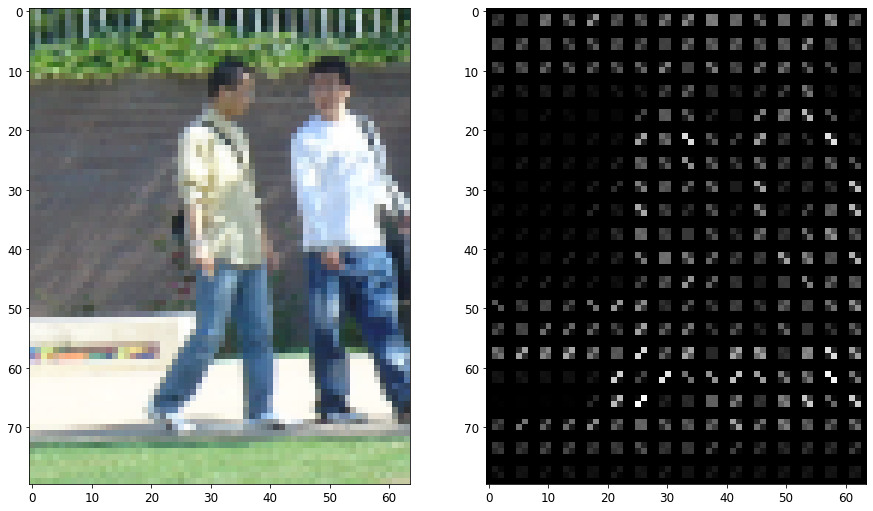

In [24]:
# img (w,h): (64,80)
# NFEATURES = nblocks * norientations/cell * ncells/block
CELL_PIXELSHAPE = (4,4)
NORIENTATIONS = 12
CELLS_PER_BLOCK = (1,1)

def list_mul(l, num):
    return tuple(map(lambda x: int(num * x), l))

def run_hog(img, visualize=False):
    result = hog(img, orientations=NORIENTATIONS, 
                 pixels_per_cell=CELL_PIXELSHAPE, cells_per_block=CELLS_PER_BLOCK, 
                 block_norm='L2', visualize=visualize, multichannel=True)
    return result

DEMO = True
if DEMO:
    fn = 'item_00000000.pnm'
    fp = os.path.join(DIR,'train','train_positive_A','00000000',fn)
    start_time = time.time()
    img = io.imread(fp)
    # (compute cell size): #cell_pixelshape = list_mul(img.shape[:2], 1/DIVISOR_NCELLS)
    # hog feature descriptors
    hog_fd, hog_img = run_hog(img, True)
    print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
    print('HOG descriptor size:', hog_fd.shape)
    # display results
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(hog_img, cmap=plt.get_cmap('gray'))

    # ax = plt.gca();    # plot grid lines
    # ax.grid(color='w', linestyle='-', linewidth=2)

In [25]:
def get_dataset_fp(is_train):
    if is_train:
        subroot = 'train'
    else:
        subroot = 'test'
    base_fp = os.path.join(DIR, subroot)
    pos_dirs = []
    neg_dirs = []
    for dir_name in os.listdir(base_fp): # all files & dirs
        subfp = os.path.join(base_fp, dir_name)
        if not os.path.isdir(subfp):
            continue    
        for subdir_name in os.listdir(subfp):
            subsubfp = os.path.join(subfp, subdir_name)
            if not os.path.isdir(subsubfp):
                continue
            if 'positive' in dir_name:
                pos_dirs.append(subsubfp)
            elif 'negative' in dir_name:
                neg_dirs.append(subsubfp)
    return pos_dirs, neg_dirs

def get_subset_images(fp, preproc=False):
    results = []
    for img_fn in os.listdir(fp):
        img_fp = os.path.join(fp, img_fn)
        if os.path.isdir(img_fp) or img_fn[-4:].lower() != '.pnm':
            continue
        img = io.imread(img_fp)
        if preproc: # proprocess as HOG
            hog_fd = run_hog(img)
            results.append(hog_fd)
    return results

NO_PERSON = 0
IS_PERSON = 1

def load_images(is_train, shuffle, NPOS_DIRS=None, NNEG_DIRS=None):
    print('\n[Loading Images]:')
    pos_dirs, neg_dirs = get_dataset_fp(is_train=is_train)
    if NPOS_DIRS == None:
        NPOS_DIRS = len(pos_dirs)
    if NNEG_DIRS == None:
        NNEG_DIRS = len(neg_dirs)
    
    x_train = []
    y_train = []
    # get preprocessed training/testing data
    for fp in pos_dirs[:NPOS_DIRS]:
        start_time = time.time()
        x_train += get_subset_images(fp, True)
        print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
    pos_length = len(x_train)
    y_train += [IS_PERSON] * pos_length
    
    for fp in neg_dirs[:NNEG_DIRS]:
        start_time = time.time()
        x_train += get_subset_images(fp, True)
        print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
    y_train += [NO_PERSON] * (len(x_train) - pos_length)
    
    # shuffle training data
    print('Reformatting data...')
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    if shuffle:
        y_train = y_train.reshape(len(y_train),1)
    #print('x: {}, y: {}'.format(x_train.shape, y_train.shape))
    #return x_train,y_train,None

    if shuffle:
        data_frame = np.hstack((x_train,y_train))
        print('Reshuffling data...')
        start_time = time.time()
        np.random.shuffle(data_frame)
        x_train = data_frame[:,:-1]
        y_train = data_frame[:,-1:].ravel()
        print('{:.3f}s runtime: shuffling'.format(time.time() - start_time))
    return x_train, y_train
    
def gen_model(model_fn, x_train, y_train):
    # generate SVM model
    print('\n[Training SVM model]:')
    start_time = time.time()
    clf = svm.SVC(probability=True)
    clf.fit(x_train, y_train)
    print('{:.3f}s runtime: training'.format(time.time() - start_time))
    
    # save SVM model
    with open(model_fn, 'wb') as fh:
        pickle.dump(clf, fh)
    
    return clf

In [26]:
SVM_MODEL = 'svm_model.pickle'
if SVM_MODEL not in os.listdir('.'):
    x_train, y_train = load_images(True,True, 3,3)
    clf = gen_model(SVM_MODEL,x_train,y_train)
    print('Images loaded:', len(x_train))
else:
    with open(SVM_MODEL, 'rb') as fh:
        print('\n[Loading Pre-Generated Model]')
        clf = pickle.load(fh)


[Loading Images]:
5.501s runtime: Individual_Component\train\train_positive_A\00000000
5.979s runtime: Individual_Component\train\train_positive_A\00000001
5.081s runtime: Individual_Component\train\train_positive_A\00000002
5.042s runtime: Individual_Component\train\train_negative_A\00000000
4.950s runtime: Individual_Component\train\train_negative_A\00000001
5.387s runtime: Individual_Component\train\train_negative_A\00000002
Reformatting data...
Reshuffling data...
0.068s runtime: shuffling

[Training SVM model]:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


273.344s runtime: training


In [29]:
# test images
#x_test, y_test = load_images(False,False)

pos_testdirs, neg_testdirs = get_dataset_fp(is_train=False)
for fp in pos_testdirs:
    print('\nTesting subset:', fp)
    start_time = time.time()
    x_test = get_subset_images(fp, True)
    y_test = [IS_PERSON] * len(x_test)
    print('  * {:.3f}s image load time'.format(time.time() - start_time))
    
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)
    print('  * y_prob {}:  {}', y_prob.shape, y_prob)
    print('  * AUC (weighted): {:.3f}'.format(metrics.roc_auc_score(y_test, y_prob, average='weighted')))
    print('  * Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('  * Recall (weighted): {:.3f}'.format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print('  * Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred))


Testing subset: Individual_Component\test\test_positive\00000000
  * 5.188s image load time
  * y_prob {}:  {} (1000, 2) [[1.24274515e-02 9.87572548e-01]
 [3.73556892e-03 9.96264431e-01]
 [1.37962744e-07 9.99999862e-01]
 ...
 [3.88107559e-01 6.11892441e-01]
 [3.38058592e-03 9.96619414e-01]
 [2.54783499e-06 9.99997452e-01]]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.